In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
# from problems.ising_problem2 import IsingProblem2
from problems.ising_problem import IsingProblem
from problems.toy_problem import ToyProblem
from cost_function import cost_loc, calc_err
from hyperparameters import *

import time

In [2]:
# Import the library that you need in order to use your IBM account
import qiskit_ibm_provider
from .secrets import IBM_token


try:
    qiskit_ibm_provider.IBMProvider()
except:
    qiskit_ibm_provider.IBMProvider.save_account(token=IBM_token, overwrite=True)

In [3]:
n_qubits = 2
error = 0.01
cond_num = 50

problem = ToyProblem(
    n_qubits=n_qubits,
)

In [4]:
# error = 0.3 # paper uses 0.01 and lower but its not converging that fast
# cond_num = 10
# n_qubits = 3

# problem = IsingProblem(
#     n_qubits=n_qubits,
#     J=0.1,
#     cond_num=cond_num
# )

In [5]:
len(problem.c)

2

In [6]:
# print(problem.get_eta_zeta()) # looks accurate

In [7]:
w = q_delta * np.random.randn(problem.param_shape, requires_grad=True)

In [8]:
# dev_mu = qml.device("default.qubit", wires=n_qubits+1)
dev_mu = qml.device("qiskit.aer", wires=n_qubits+1)

In [9]:
from IPython.display import clear_output

opt = qml.GradientDescentOptimizer(eta)

cost_history = []

err = float("inf")
it = 1

In [10]:
start = time.time()
while err > error:
# for it in range(steps):
    w, cost = opt.step_and_cost(lambda w: cost_loc(problem, w, dev_mu), w)

    err = calc_err(n_qubits, cost, cond_num)
    
    clear_output(wait=True)

    print("Step {:3d}       Cost_L = {:9.7f} \t error = {:9.7f}".format(it, cost, err), flush=True)
    cost_history.append(cost)

    it += 1

print(f"Training time: {time.time() - start}s")

Step   5       Cost_L = -0.0004550 	 error =       nan
Training time: 12.019959926605225s


### Optimization studies:
- each epoch is taking ~ 20s
- Each $\mu$ calculation takes ~0.05s but occasionally spikes to ~0.3s
- Each $\mu_{sum}$ has to loop over each combination of A_l for each qubit -> $c^2n$ operations -> ~15s
- Each $|\psi|$ also has to loop over each combination, but we're unable to recycle computation because these don't apply $CZ$ like the above -> ~4s
- The ising problem has 8 C's
    - Note that `len(c) = n_qubits * 2` by definition of H_ising
- 8 * 8 * 4 * 2 = ~512 mu accumulations

--> $8n^3 + 4n^2$ iterations

It should be possible to multithread the calculation, but not sure if that's feasible when testing on an actual QC


* n_qubits = 5: 1100 mu accumulations
* n_qubits = 6: 1872 mu accumulations
* n_qubits = 7: 2940 mu accumulations

/var/folders/46/x_y_zr5s2rj1v37fwfjmjh9r0000gn/T/ipykernel_98476/3273331246.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


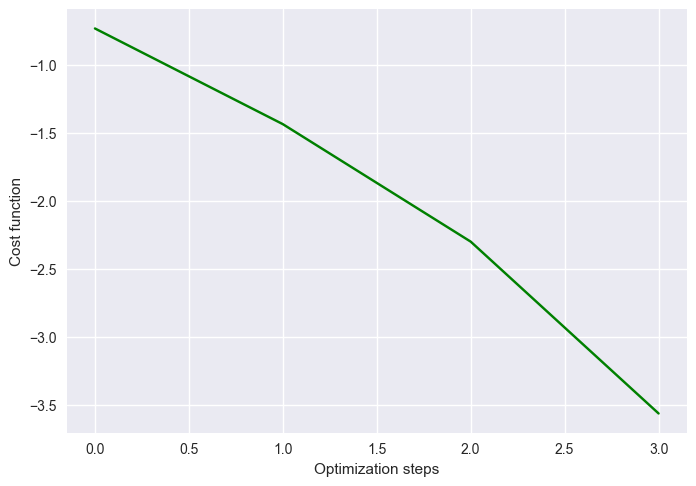

In [11]:
plt.style.use("seaborn")
plt.plot(np.log(cost_history), "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Qualitatively, it's converging slower than the toy problem, suggesting more iterations are needed

In [12]:
from inference import get_cprobs, get_qprobs
c_probs = get_cprobs(problem)

dev_x = qml.device("qiskit.aer", wires=n_qubits, shots=n_shots)
# dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)
q_probs = get_qprobs(problem, w, dev_x)

/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'problems', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


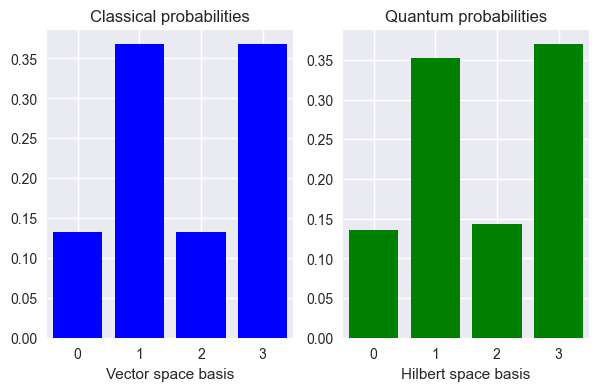

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()